In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:

def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .drop('unnamed: 36', axis=1)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return  pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        return datetime_part
    df[columns] = df[columns].apply(converter)
    return df


In [7]:
df = read('317233692_T_ONTIME.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471949 entries, 0 to 471948
Data columns (total 36 columns):
fl_date                  471949 non-null datetime64[ns]
unique_carrier           471949 non-null category
airline_id               471949 non-null int64
tail_num                 467903 non-null category
fl_num                   471949 non-null int64
origin_airport_id        471949 non-null int64
origin_airport_seq_id    471949 non-null int64
origin_city_market_id    471949 non-null int64
origin                   471949 non-null category
origin_city_name         471949 non-null object
origin_state_nm          471949 non-null object
dest_airport_id          471949 non-null int64
dest_airport_seq_id      471949 non-null int64
dest_city_market_id      471949 non-null int64
dest                     471949 non-null category
dest_city_name           471949 non-null object
dest_state_nm            471949 non-null object
crs_dep_time             471949 non-null datetime64[ns]
dep_time 

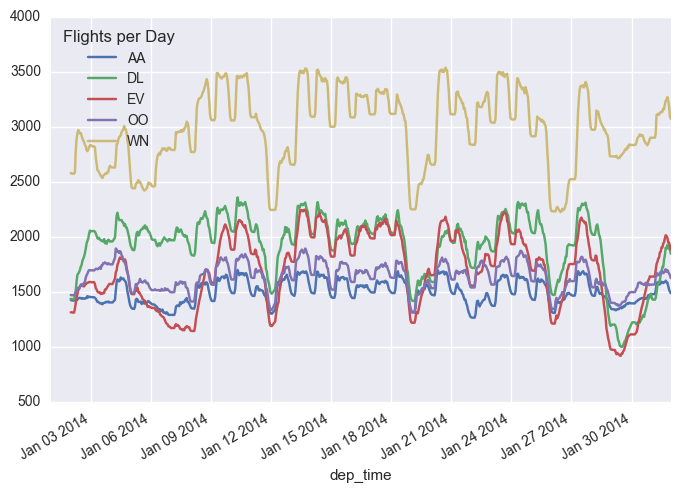

In [76]:
(df.dropna(subset=['dep_time', 'unique_carrier'])
   .loc[df['unique_carrier']
       .isin(df['unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   # TimeGrouper to resample & groupby at once
   .groupby(['unique_carrier', pd.TimeGrouper("H")])
   .fl_num.count()
   .unstack(0)
   .fillna(0)
   .rolling(24)
   .sum()
   .rename_axis("Flights per Day", axis=1)
   .plot()
)
sns.despine()
plt.show()